In [1]:
# !pip install pytrends
# !pip install fbprophet

In [8]:
from pytrends.request import TrendReq
import pandas as pd
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')


In [9]:
pytrends = TrendReq(hl='en-US', tz=360)

In [10]:
# Initial test
kw_list = ["Career Change"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='US', gprop='')

In [11]:
career_change_top = pytrends.related_queries()[kw_list[0]]["top"]

In [12]:
new_list = []
for x in kw_list:
    for l in x:
        new_list.append(l)
len(new_list)

13

In [16]:
# Job site searches; top job search sites via RH
kw_list = ["Robert Half","Career Builder","Indeed",'Monster','Glassdoor']
pytrends.build_payload(kw_list, cat=0, timeframe='2005-01-01 2018-12-31', geo='US', gprop='')

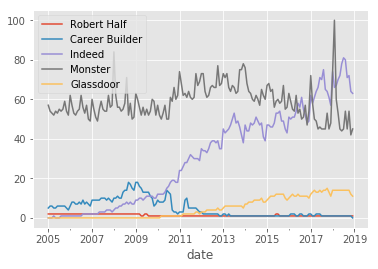

In [17]:
pytrends.interest_over_time().plot()

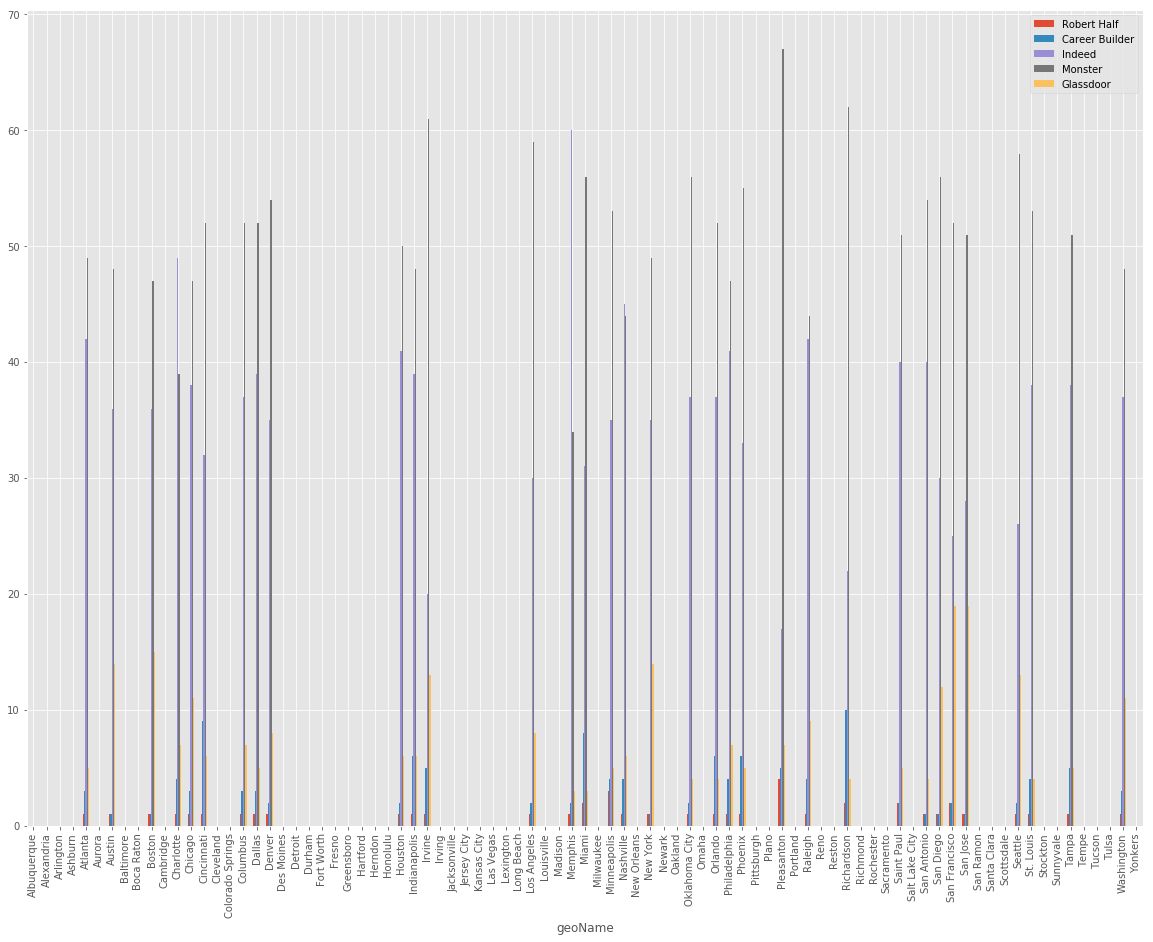

In [18]:
pytrends.interest_by_region(resolution="CITY").plot.bar(figsize=[20,15])

In [19]:
kw_list = ["Robert Half","Career Builder"]
pytrends.build_payload(kw_list, cat=0, timeframe='2005-01-01 2018-12-31', geo='US', gprop='')

In [20]:
df_rh_cb = pytrends.interest_over_time()

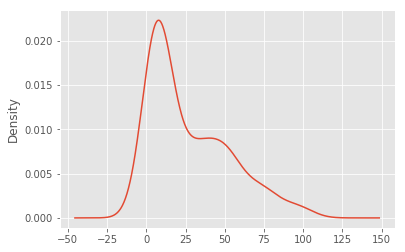

In [21]:
# Can solve relative information, but finding mean of this information and noting normal distribution curve/where they spike
df_rh_cb["Career Builder"].plot.kde()

In [22]:
kw_list = ['job']
pytrends.build_payload(kw_list, cat=0, timeframe='2005-01-01 2018-12-31', geo='US', gprop='')

In [23]:
df_job = pytrends.interest_over_time()

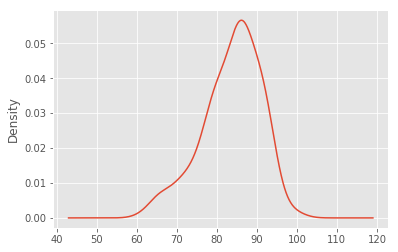

In [24]:
df_job.job.plot.kde()

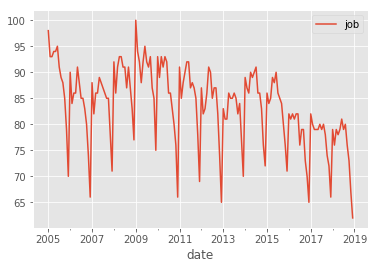

In [25]:
# Steve Jobs died in October 2011; so we'll use job
df_job.plot()

In [26]:
kw_list = ['career']
pytrends.build_payload(kw_list, cat=0, timeframe='2005-01-01 2018-12-31', geo='US', gprop='')

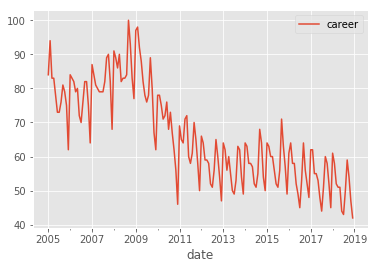

In [27]:
pytrends.interest_over_time().plot()

In [28]:
kw_list = ['work']
pytrends.build_payload(kw_list, cat=0, timeframe='2005-01-01 2018-12-31', geo='US', gprop='')

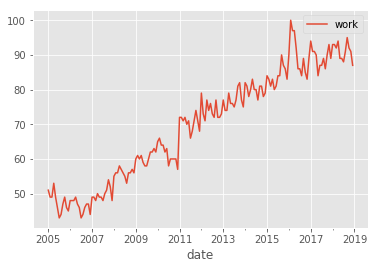

In [29]:
# Rihanna's Song "Work" was released in 2016
pytrends.interest_over_time().plot()

In [30]:
def arima_modeler(data,pdq_lower,pdq_upper,m):
    p = d = q = range(pdq_lower, pdq_upper)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data,
                                order=ans_df.loc[ans_df['aic'].idxmin()][0],
                                seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    return output

def dataframe_converter(df,column_name):
    new = df.resample('MS').mean()
    return pd.to_numeric(new[str(column_name)],downcast="float")

In [31]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [32]:
job_input = dataframe_converter(df_job,"job")

In [33]:
# df_job_arima = arima_modeler(arima_input,0,2,12)

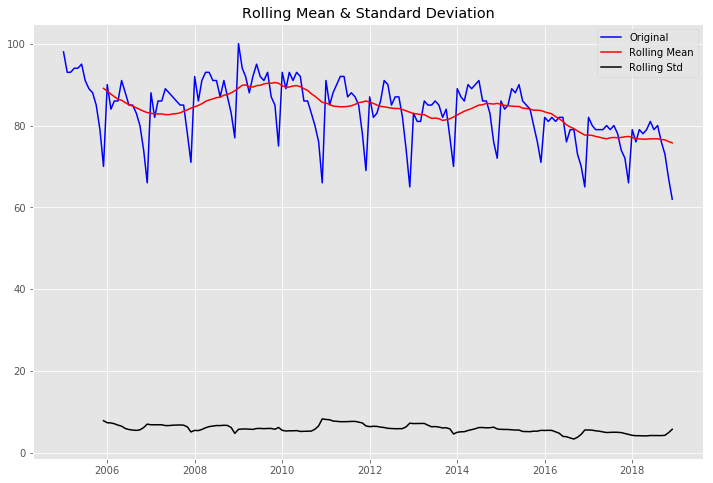

Results of Dickey-Fuller Test:
Test Statistic                  -0.793223
p-value                          0.821105
#Lags Used                      14.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


In [34]:
test_stationarity(job_input)

In [35]:
# Dickey Fuller Testing
from statsmodels.tsa.stattools import adfuller

In [36]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

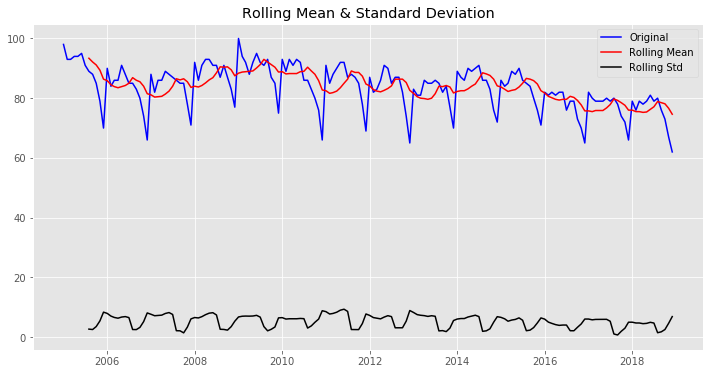

Results of Dickey-Fuller Test:
Test Statistic                  -0.793223
p-value                          0.821105
#Lags Used                      14.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


In [37]:
stationarity_check(job_input)

In [38]:
# Does transforming look any better?
ts_log = np.log(job_input)
ts_sqrt= np.sqrt(job_input)
fig = plt.figure(figsize=(12,6))
plt.plot(arima_input,  color='blue');
plt.title('Original')
plt.show()
fig = plt.figure(figsize=(12,6))
plt.plot(ts_log, color='blue');
plt.title('Log')
plt.show()
fig = plt.figure(figsize=(12,6))
plt.title('Sqrt')
plt.plot(ts_sqrt, color='blue');
# Result: Going to use log -- since the raw values are closer to each other
# On the other hand, i don't see any appreciable change in values, so I'm thinking the relative strength of each value already trends this data

NameError: name 'arima_input' is not defined

<Figure size 864x432 with 0 Axes>

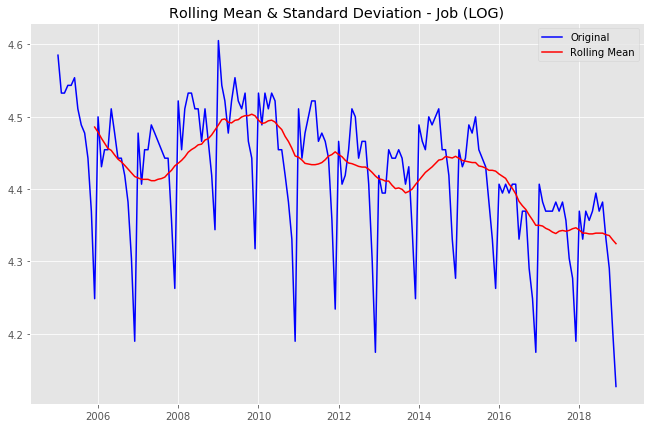

In [39]:
# START: LOG-specific review
# Rolling mean with log'd values
rolmean = np.log(job_input).rolling(window = 12).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(np.log(job_input), color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation - Job (LOG)')
plt.show(block=False)
# Interesting Observation: it almost looks like people searching for jobs falls after unemployment actually goes up

In [40]:
data_minus_rolmean_log = np.log(job_input) - rolmean
# Adding in rolmean creates NaNs for first year
data_minus_rolmean_log.dropna(inplace=True)

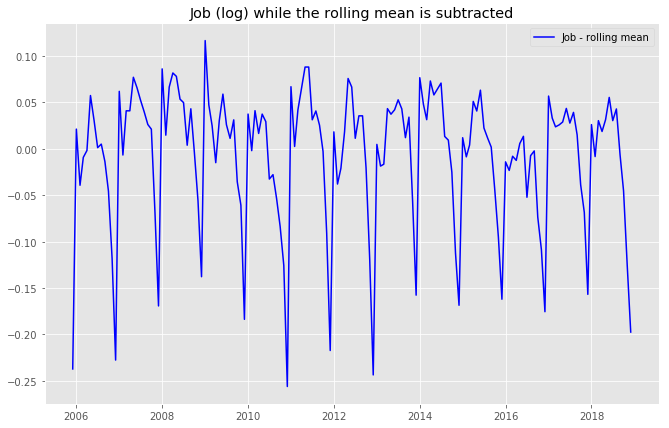

In [41]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean_log, color='blue',label='Job - rolling mean')
plt.legend(loc='best')
plt.title('Job (log) while the rolling mean is subtracted')
plt.show(block=False)

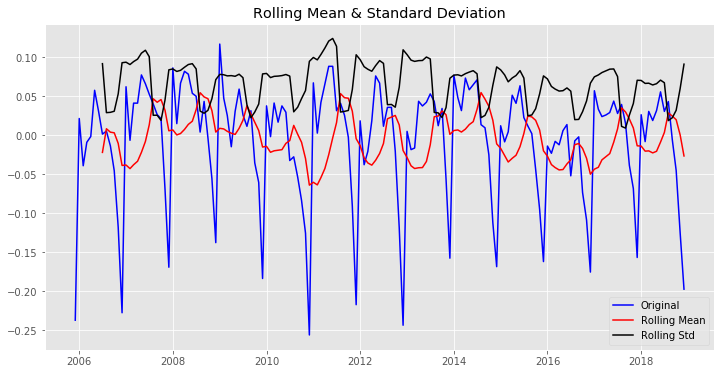

Results of Dickey-Fuller Test:
Test Statistic                  -3.300158
p-value                          0.014871
#Lags Used                      14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [42]:
# Cool! 95% Statistically Significant Results!
stationarity_check(data_minus_rolmean_log)

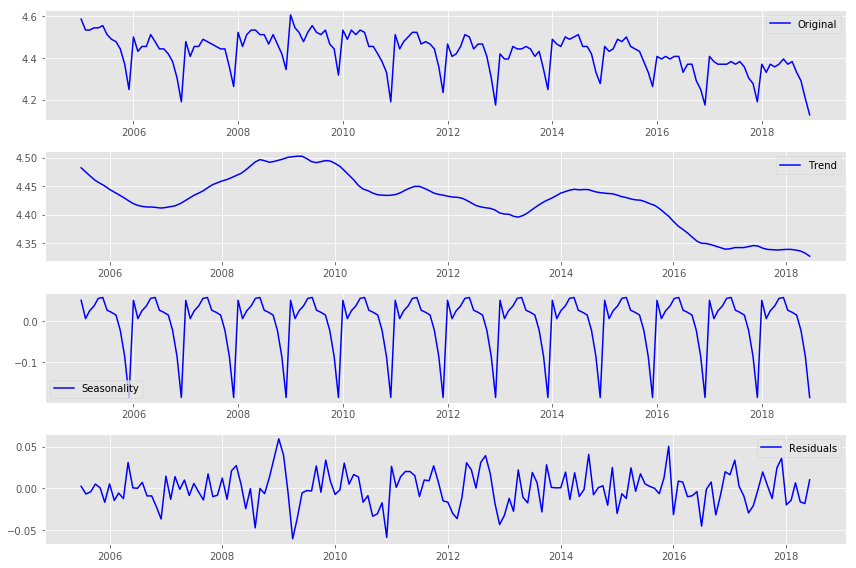

In [43]:
# Other Stationarity removals

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(job_input))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(job_input), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

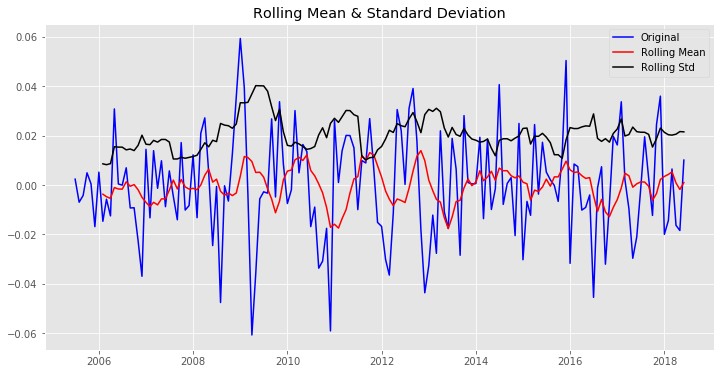

Results of Dickey-Fuller Test:
Test Statistic                  -4.592714
p-value                          0.000133
#Lags Used                      13.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [44]:
# Drop NaN values from residuals.
ts_log_decompose_log = residual
ts_log_decompose_log.dropna(inplace=True)

# Check stationarity
stationarity_check(ts_log_decompose_log)
# p-value significantly improved!

In [45]:
job_log_arima_decompose = arima_modeler(ts_log_decompose_log,0,2,12)

pdq         (1, 0, 0)
pdqs    (0, 0, 0, 12)
aic          -759.554
Name: 32, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1921      0.073      2.635      0.008       0.049       0.335
sigma2         0.0004   4.83e-05      8.789      0.000       0.000       0.001


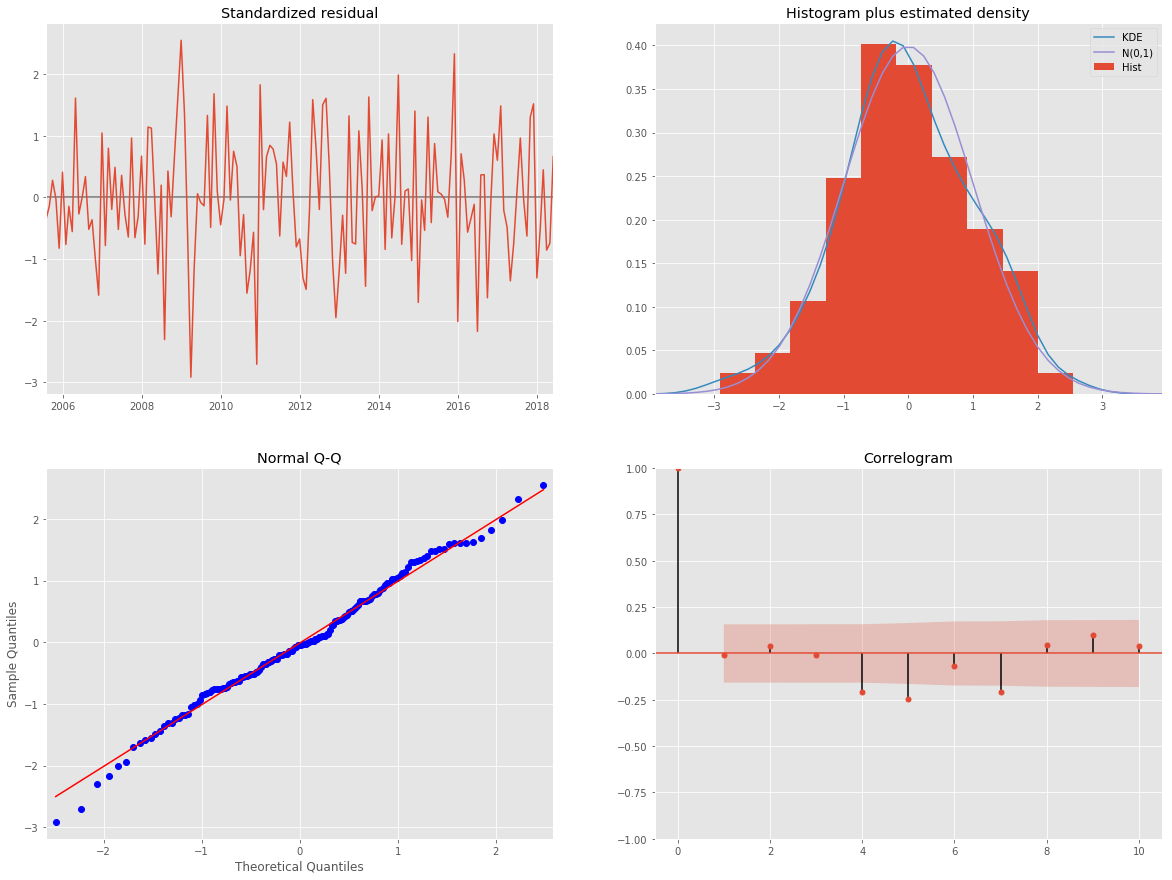

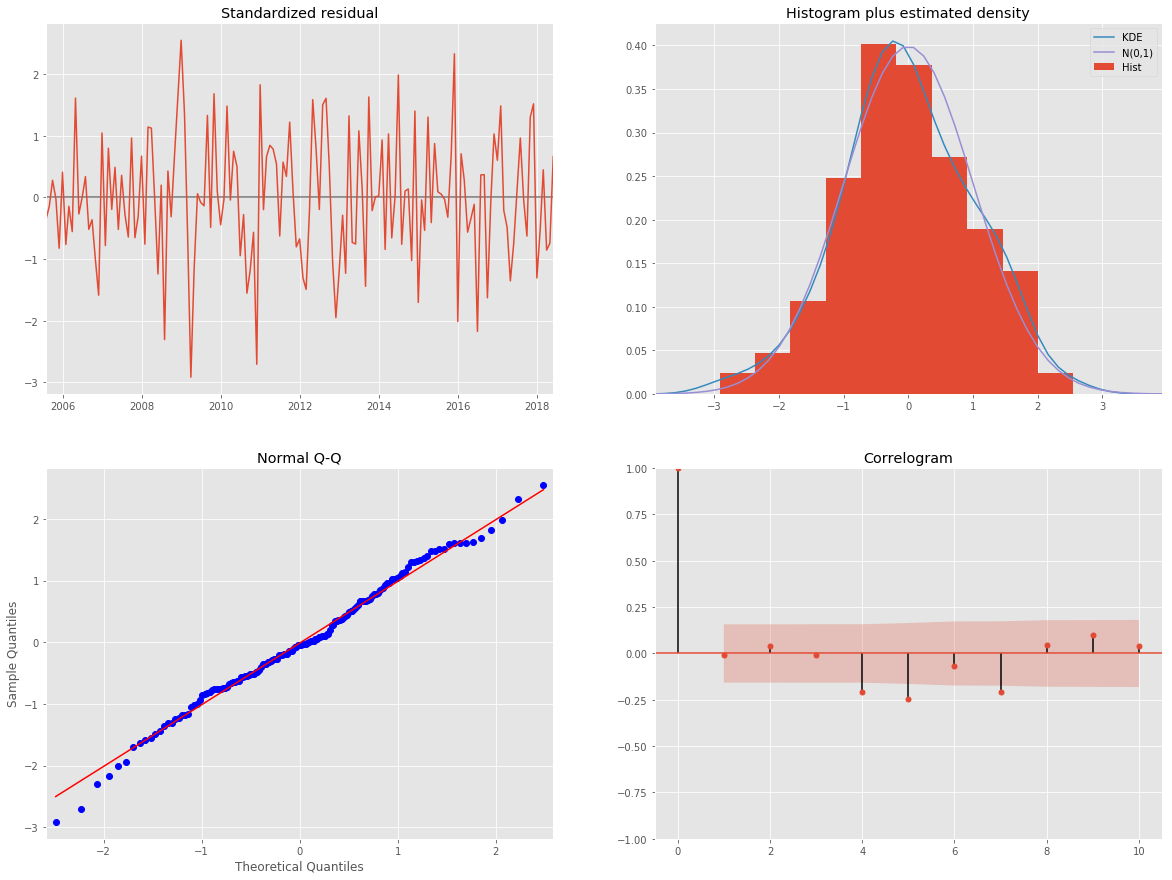

In [46]:
job_log_arima_decompose.plot_diagnostics(figsize=[20,15])

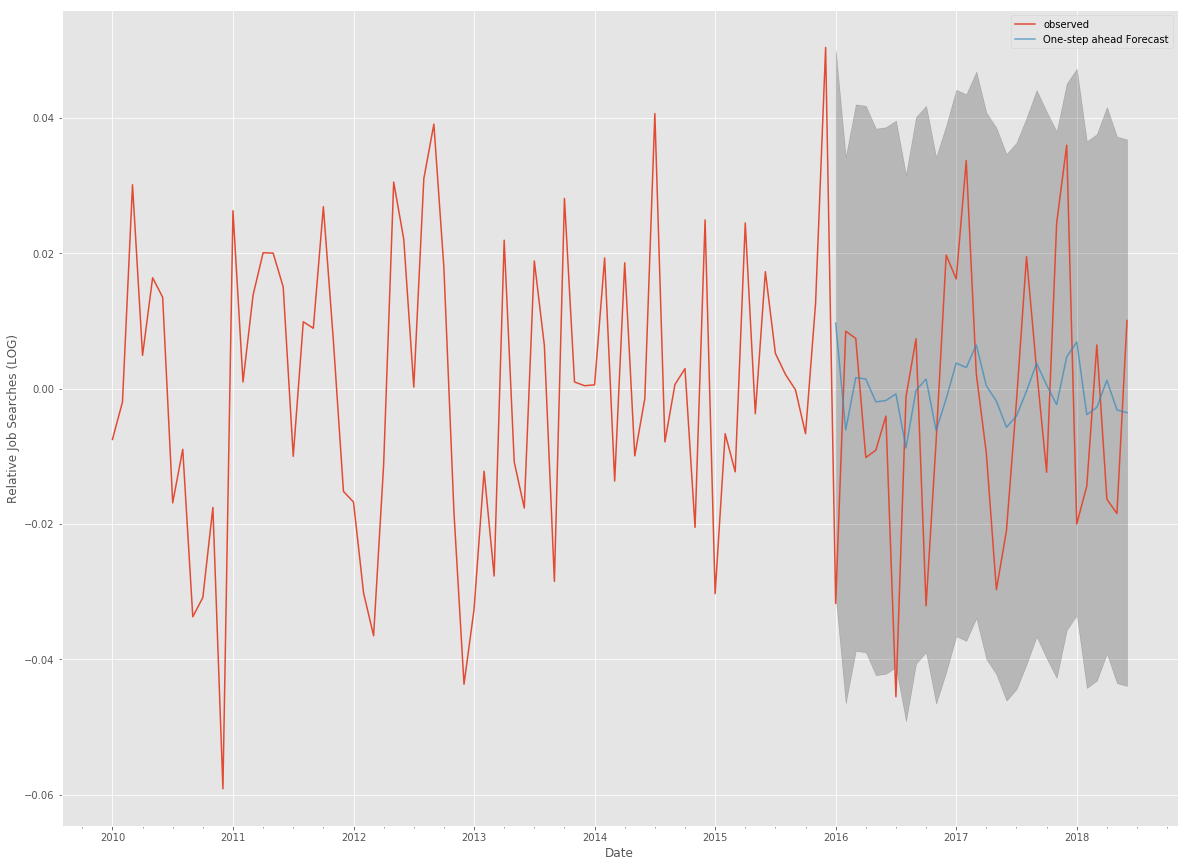

In [47]:
pred = job_log_arima_decompose.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts_log_decompose_log['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 15))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Relative Job Searches (LOG)')
plt.legend()
plt.show()

In [48]:
# RMSE/MSE; the RMSE says we're about .02 off on average
y_forecasted = pred.predicted_mean
y_truth = ts_log_decompose_log['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 8)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 8)))

The Mean Squared Error of our forecasts is 0.00034094
The Root Mean Squared Error of our forecasts is 0.01846464


In [49]:
# Testing the non-log forecast

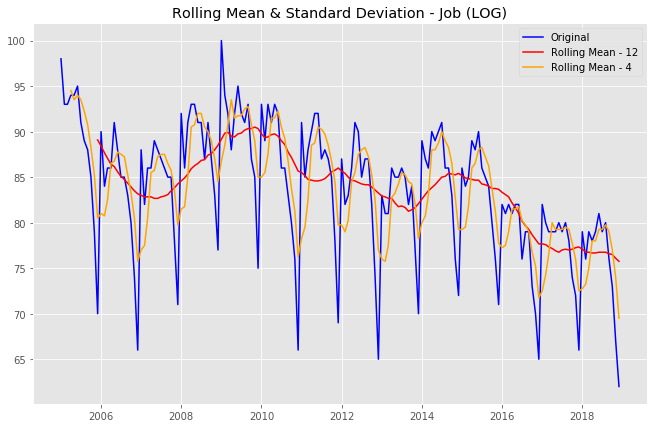

In [50]:
rolmean = job_input.rolling(window = 12).mean()
rolmean_q = job_input.rolling(window = 4).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(job_input, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean - 12')
mean_q = plt.plot(rolmean_q, color='orange', label='Rolling Mean - 4')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation - Job (LOG)')
plt.show(block=False)


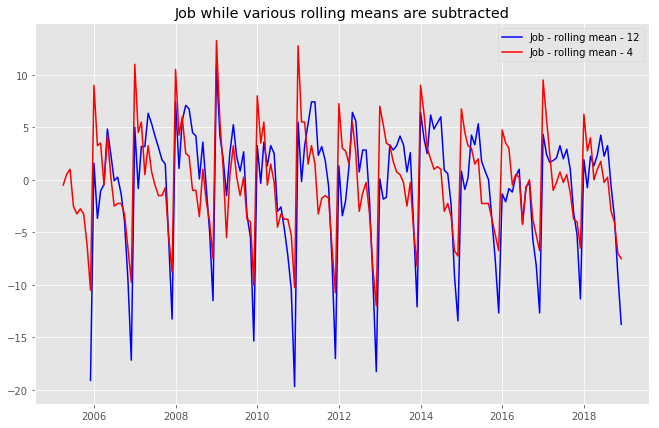

In [51]:
data_minus_rolmean = job_input - rolmean
data_minus_rolmean_q = job_input - rolmean_q
# data_minus_rolmean_both = job_input - rolmean - rolmean_q
# Adding in rolmean creates NaNs for first year
data_minus_rolmean.dropna(inplace=True)
data_minus_rolmean_q.dropna(inplace=True)
# data_minus_rolmean_both.dropna(inplace=True)

# Plot rollingmean
fig = plt.figure(figsize=(11,7))
# orig = plt.plot(job_input, color='blue',label='Original')
plt.plot(data_minus_rolmean, color='blue',label='Job - rolling mean - 12')
plt.plot(data_minus_rolmean_q, color='red',label='Job - rolling mean - 4')
# plt.plot(data_minus_rolmean_both, color='orange',label='Job - rolling mean - 4 & 12')
plt.legend(loc='best')
plt.title('Job while various rolling means are subtracted')
plt.show(block=False)

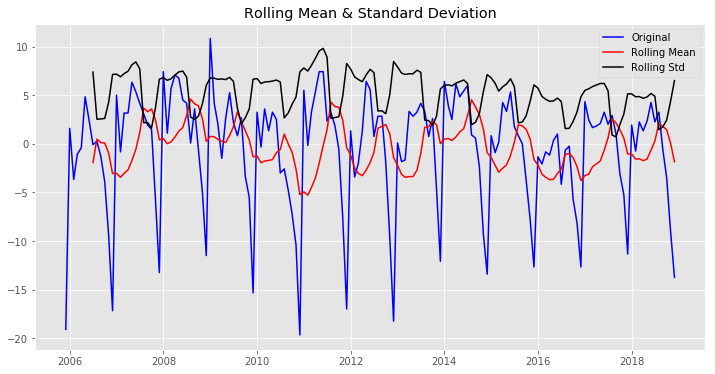

Results of Dickey-Fuller Test:
Test Statistic                  -3.259402
p-value                          0.016794
#Lags Used                      14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [52]:
# Cool! 95% Statistically Significant Results!
stationarity_check(data_minus_rolmean)

In [ ]:
# Slightly better results than the 12 lag
stationarity_check(data_minus_rolmean_q)

In [ ]:
# Other Stationarity removals

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(job_input)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(job_input, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Drop NaN values from residuals.
job_decompose = residual
job_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(job_decompose)
# p-value significantly improved!

In [ ]:
job_arima_decompose = arima_modeler(job_decompose,0,2,12)

In [ ]:
job_arima_decompose.plot_diagnostics(figsize=[20,15])

In [ ]:
pred = job_arima_decompose.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = job_decompose['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 15))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Relative Job Searches (Raw)')
plt.legend()
plt.show()

In [ ]:
# RMSE/MSE; the RMSE says we're about .02 off on average
y_forecasted = pred.predicted_mean
y_truth = job_decompose['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 8)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 8)))

In [ ]:
# Import Unemployment Data
df = pd.read_excel('BLS_SA_Unemployment.xlsx',header=3)

In [ ]:
df_unempl = df.transpose()
df_unempl = df_unempl.iloc[1:]
df_unempl.columns = ["seasonally_adjusted_unemployment_rate"]
date_rng = pd.date_range(start='1/1/1948', end='12/31/2018', freq='MS')
df_unempl.index = date_rng
df_unempl = df_unempl.loc["2005-01-01":]
df_unempl.head()

In [ ]:
df_unempl.plot()

In [ ]:
unempl_input = np.log(dataframe_converter(df_unempl,"seasonally_adjusted_unemployment_rate"))

In [ ]:
# Other Stationarity removals

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(unempl_input)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(unempl_input, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Drop NaN values from residuals.
unempl_decompose = residual
unempl_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(unempl_decompose)
# p-value significantly improved!

In [ ]:
unempl_arima_decompose = arima_modeler(job_decompose,0,2,4)

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_log_decompose_log, label='Job', color="red")
plt.plot(unempl_decompose, label='Job', color="blue")